# 안내

본 실습자료는, 여러분들이 공공데이터포털과 같은 open data repository로부터 단변량 시계열데이터를 직접 다운로드 받아서, ARIMA 모델을 적용해볼 수 있는 자료입니다.

* **Goal**: 실제 시계열 데이터에 활용 ARIMA모델 적용해보기
* **공공데이터 예시**:
  *  기상자료개방포털(https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do)
  *  UC Irvine Data Repository (https://archive.ics.uci.edu/datasets?NumInstances=100-1000&FeatureTypes=Numerical&skip=0&take=10&sort=desc&orderBy=NumHits&search=&Types=Time-Series)

* **조건**:
  1. 단변량 시계열 데이터 활용
  2. 기한: **2024년 5월 17일 오후 6시**
  3. 제출처: e-class
  4. 제출파일: 이름_analysis.ipynb 및 1-page report
  5. 리포트 필수 포함 내용 (제한 분량: 1 page)

    a) 데이터셋의 선정 이유 및 시계열 모델이 필요한 이유
    
    b) 적합한 모델의 선정
    
    c) (예측)결과에 대한 고찰
  
  6. python notebook (.ipynb) 필수 포함 내용

    a) 각 cell의 code 및 output  



# **Python 실습 (ARIMA)**


*   서울지역의 연강수량 시계열 데이터를 통한 python 실습



In [40]:
# Library 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# 데이터 불러오기
ts0 = pd.read_csv('seoul_yearly_summer_humidity_1954_2018.csv', encoding='cp949')
print(ts0.shape)
display(ts0.head(5))
display(ts0.tail(5))

(65, 5)


,지점번호,지점명,일시,평균습도(%rh),최저습도(%rh)
0,108,서울,1954,81.0,35
1,108,서울,1955,77.3,25
2,108,서울,1956,79.7,29
3,108,서울,1957,80.3,32
4,108,서울,1958,74.0,21


,지점번호,지점명,일시,평균습도(%rh),최저습도(%rh)
60,108,서울,2014,74.7,27
61,108,서울,2015,67.0,13
62,108,서울,2016,66.7,21
63,108,서울,2017,68.3,14
64,108,서울,2018,65.3,19


데이터 확인하기 (결측치 여부, column type 등)

In [43]:
ts0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   지점번호       65 non-null     int64  
 1   지점명        65 non-null     object 
 2   일시         65 non-null     int64  
 3   평균습도(%rh)  65 non-null     float64
 4   최저습도(%rh)  65 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 2.7+ KB


# **Exploratory Data Analysis (탐색적 데이터 분석)**

*   필요한 column만 남기고 날짜를 인덱스로 변환하기

In [44]:
# 필요한 column만 남기기
ts = ts0.loc[:, ['일시', '평균습도(%rh)']]
# 인덱스 설정 후 drop
ts.index = ts.일시
ts = ts.drop(columns="일시")
ts

,평균습도(%rh)
일시,
1954,81.0
1955,77.3
1956,79.7
1957,80.3
1958,74.0
...,...
2014,74.7
2015,67.0
2016,66.7


* 시각화 함수 정의 및 분포 시각화

In [45]:
def plot_ts(data, color, alpha, label):

    plt.figure(figsize=(11,5))
    plt.plot(data, color=color, alpha=alpha, label=label)
    plt.title("Summer mean humidity of Seoul")
    plt.xlabel('Year')
    plt.ylabel('Mean humidity')
    plt.legend()
    plt.show()

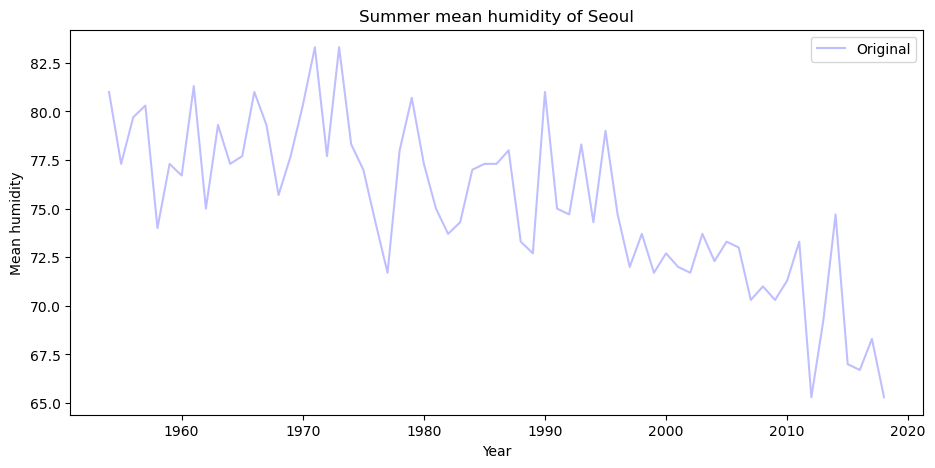

In [46]:
plot_ts(ts, 'blue', 0.25, 'Original')

# **시계열 데이터의 정상성 검정: ADF**

* statsmodels의 adfuller 함수를 통해 검정 실시
출력값 순서

1.   ADF 통계량
2.   p-value
3.   usedlag (The number of lags used)
4.   nobs (The number of observations used for the ADF regression and calculation of the critical values.)
5.   critical values (기각역)
6.   icbest (The maximized information criterion if autolag is not None.)

In [47]:
from statsmodels.tsa.stattools import adfuller

adfuller(ts, autolag='AIC')

(0.16231449272814513,
 0.9700669328692187,
 4,
 60,
 {'1%': -3.5443688564814813,
  '5%': -2.9110731481481484,
  '10%': -2.5931902777777776},
 263.0066879040797)

* ADF 결과 중 통계량, p-value, 기각역을 계산하고, 출력하는 함수 정의 및 실행

In [48]:
def ADF_test(data):
	# ADF 실시
    results = adfuller(data, autolag='AIC')

    # 통계량
    s = results[0]
    # p-value
    p = results[1]
    # 기각역
    cv = results[4]

    # 출력
    print('-'*30)
    print('Augemented Dickey-Fuller Test')
    print('H0 : 단위근이 존재한다 (비정상 시계열)')
    print('Ha : 단위근이 없다 (정상 시계열)')
    print('Critical Values : {}'.format(cv))
    print('-'*30)
    print('Test Statistics : {:.4f}'.format(s))
    print('p-value : {:.4f}'.format(p))
    print('-'*30)

In [49]:
# ts 데이터로 ADF 실행해보기
ADF_test(ts)

------------------------------
Augemented Dickey-Fuller Test
H0 : 단위근이 존재한다 (비정상 시계열)
Ha : 단위근이 없다 (정상 시계열)
Critical Values : {'1%': -3.5443688564814813, '5%': -2.9110731481481484, '10%': -2.5931902777777776}
------------------------------
Test Statistics : 0.1623
p-value : 0.9701
------------------------------


* 이동 평균 함수를 이용한 평균 및 표준편차 분포 시각화

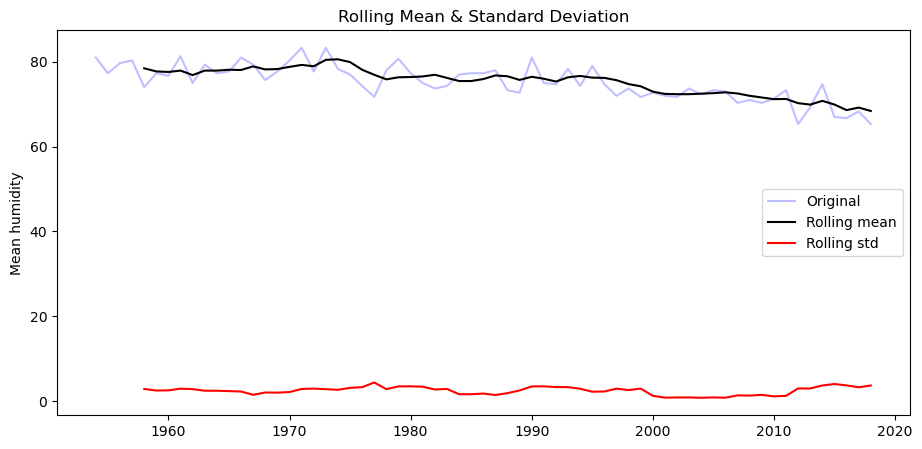

In [50]:
def plot_rolling(data, roll_size):
    # 이동평균함수(rolling) - 평균, 표준편차
    roll_mean = data.rolling(window=roll_size).mean()
    roll_std = data.rolling(window=roll_size).std()

    # 시각화
    plt.figure(figsize=(11,5))
    plt.plot(data, color='blue', alpha=0.25, label='Original')
    plt.plot(roll_mean, color='black', label='Rolling mean')
    plt.plot(roll_std, color='red', label='Rolling std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel("Mean humidity")
    plt.legend()
    plt.show()

# 함수 실행
plot_rolling(ts, 5)

# **Differencing으로 정상시계열 만들기**

*  방법 1. `.shift()` 함수 사용

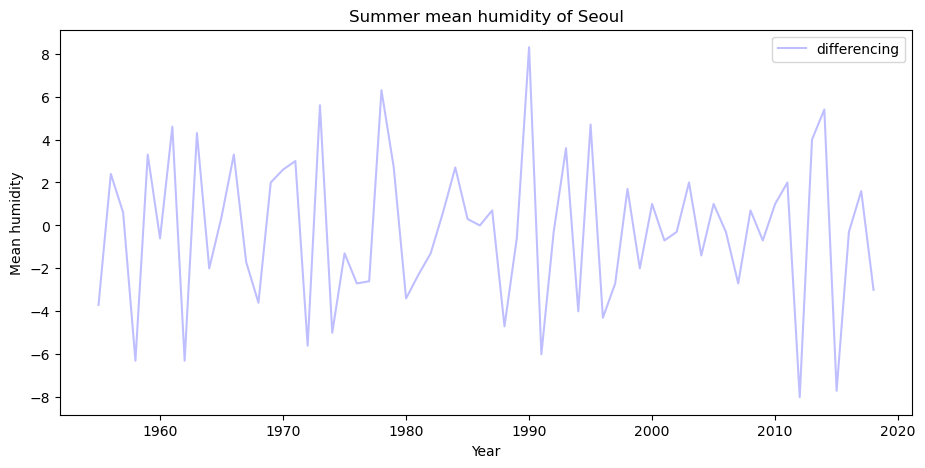

In [51]:
# ts에서 ts.shift(1)을 빼기 (1차 차분)
ts_diff = ts - ts.shift() # default=1임

# 시각화
plot_ts(ts_diff, color='blue', alpha=0.25, label='differencing')

* 이동평균 시각화 및 ADF 테스트 실시

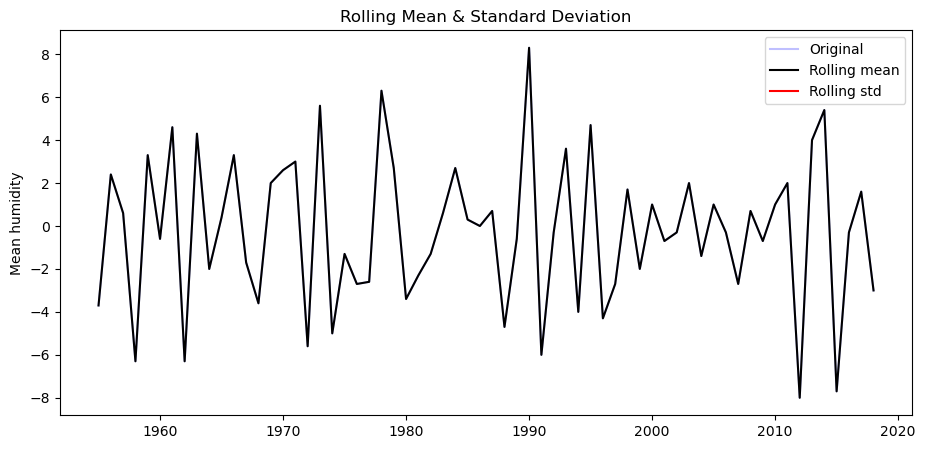

------------------------------
Augemented Dickey-Fuller Test
H0 : 단위근이 존재한다 (비정상 시계열)
Ha : 단위근이 없다 (정상 시계열)
Critical Values : {'1%': -3.5443688564814813, '5%': -2.9110731481481484, '10%': -2.5931902777777776}
------------------------------
Test Statistics : -7.1050
p-value : 0.0000
------------------------------


In [52]:
plot_rolling(ts_diff, 1)
ADF_test(ts_diff.dropna())

*  방법 2. `.diff()` 함수 사용

In [53]:
# 차분
ts_diff2 = ts.diff().dropna()

# ADF 테스트
ADF_test(ts_diff2)

------------------------------
Augemented Dickey-Fuller Test
H0 : 단위근이 존재한다 (비정상 시계열)
Ha : 단위근이 없다 (정상 시계열)
Critical Values : {'1%': -3.5443688564814813, '5%': -2.9110731481481484, '10%': -2.5931902777777776}
------------------------------
Test Statistics : -7.1050
p-value : 0.0000
------------------------------


# **ARIMA로 평년 기온 예측하기**

* ACF, PACF 계산 및 시각화

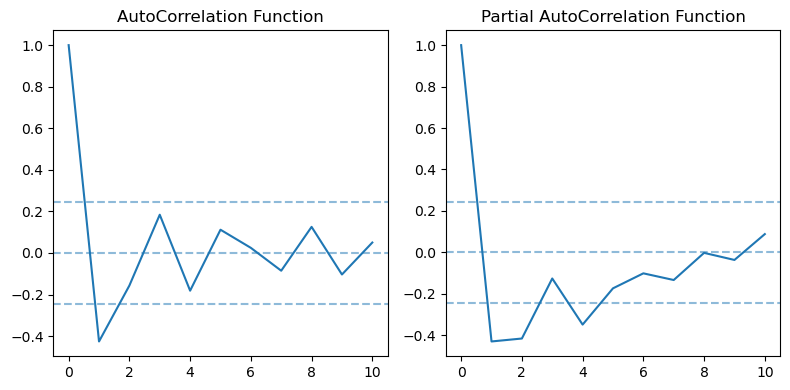

In [54]:
# ACF and PACF
from statsmodels.tsa.stattools import acf, pacf

# ACF
acf_12 = acf(x=ts_diff2, nlags=10)
# PACF
pacf_12 = pacf(x=ts_diff2, nlags=10, method='ols')

# 95% 신뢰구간 계산하기
confidence = 1.96/np.sqrt(len(ts_diff2))

# 시각화
plt.figure(figsize=(8,4))
# ACF
plt.subplot(1,2,1)
plt.plot(acf_12)
plt.axhline(y=0, linestyle='--', alpha=0.5)
plt.axhline(y=-confidence, linestyle='--', alpha=0.5)
plt.axhline(y=confidence, linestyle='--', alpha=0.5)
plt.title('AutoCorrelation Function')
# PACF
plt.subplot(1,2,2)
plt.plot(pacf_12)
plt.axhline(y=0, linestyle='--', alpha=0.5)
plt.axhline(y=-confidence, linestyle='--', alpha=0.5)
plt.axhline(y=confidence, linestyle='--', alpha=0.5)
plt.title('Partial AutoCorrelation Function')

plt.tight_layout()

### ARIMA(p, d, q)


*   최적 q값 (신뢰구간 최초 진입 시점) \\
    ACF (q, MA) = 2
*   최적 p값 (신뢰구간 최초 진입 시점) \\
	  PACF (p, AR) = 3
*   예상되는 최적의 ARIMA 모델 \\
    ARIMA(2, 1, 3)

* ARIMA(1,1,1) 실시해보기 (벤치마크)


In [55]:
# ARIMA
from statsmodels.tsa.arima.model import ARIMA

# index를 period로 변환해주어야 warning이 뜨지 않음
ts_copy = ts.copy()
ts_copy.index = pd.PeriodIndex(ts.index, freq='Y')

# 예측을 시작할 위치(이후 차분을 적용하기 때문에 맞추어주었음
start_idx = ts_copy.index[1]

# ARIMA(1,1,1)
model1 = ARIMA(ts_copy, order=(1,1,1))
# fit model
model1_fit = model1.fit()

# 전체에 대한 예측 실시
forecast1 = model1_fit.predict(start=start_idx)
forecast1.index = ts.index[1:]
forecast1

일시
1955    80.999515
1956    79.083950
1957    79.299758
1958    79.617231
1959    78.020108
          ...    
2014    69.969111
2015    71.165324
2016    70.136408
2017    69.237631
2018    68.978527
Name: predicted_mean, Length: 64, dtype: float64

* 예측 시각화 및 오차함수(MSE) 함수 정의 및 실시

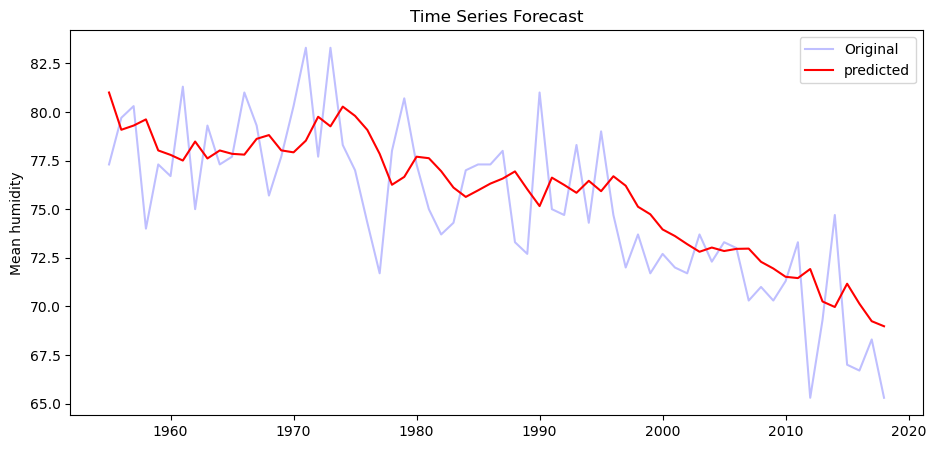

Mean Squared Error : 8.0793


In [56]:
from sklearn.metrics import mean_squared_error

def plot_and_error(data, forecast):
    # MSE 계산
    mse = mean_squared_error(data, forecast)
    # 시각화
    plt.figure(figsize=(11,5))
    plt.plot(data, color='blue', alpha=0.25 , label='Original')
    plt.plot(forecast, color='red', label='predicted')
    plt.title("Time Series Forecast")
    plt.ylabel("Mean humidity")
    plt.legend()
    plt.show()
    # MSE 출력
    print('Mean Squared Error : {:.4f}'.format(mse))

plot_and_error(ts[1:]['평균습도(%rh)'], forecast1)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


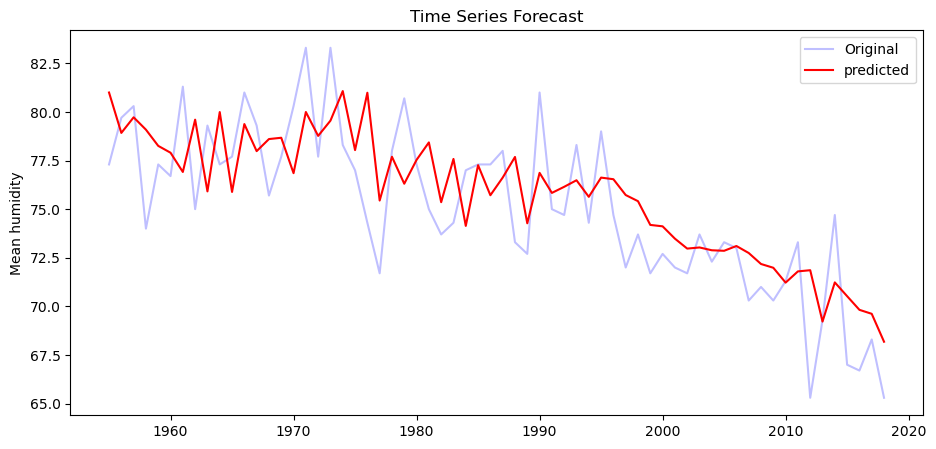

Mean Squared Error : 7.2999


In [57]:
# 모델 파라미터 최적화 (p=2, d=1, q=3)
model2 = ARIMA(ts_copy, order=(2,1,3))
# fit
model2_fit = model2.fit()
# 예측
forecast2 = model2_fit.predict(start=start_idx)
forecast2.index = ts.index[1:]
# 시각화 및 MSE 연산
plot_and_error(ts[1:], forecast2)

--------------

# Auto ARIMA
* 현재까지는 ARIMA의 p,d,q값을 직접적으로 설정하는 방식을 통해 모델링과 최적화를 진행하였지만, ACF나 PACF의 경우엔 다소 주관적으로 판단해야하는 경우가 있었습니다.
* Auto ARIMA는 이러한 파라미터의 탐색과정을 자동화하여 보다 쉽고 정확하게 가장 높은 성능을 이끌어 낼 수 있도록 최적화할 수 있도록 하는 Tool이며, Auto ARIMA를 지원하는 다양한 라이브러리들이 있습니다.
* 보통 머신러닝에서는 Grid Search나 Bayesian Search를 통해 하이퍼파라미터를 최적화하는데, Auto ARIMA는 Bayesian Search의 방식에 좀 더 가까운 방식으로 동작합니다.
* stepwise algorithm : Hyndman and Khandakar (2008)의 알고리즘으로 가능한 모든 조합을 찾는 것이 아닌 주어진 상황에서 확률적으로 파라미터들을 바꾸어보면서 최적화를 진행하는 방식

In [58]:
# 기본 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
train = ts['평균습도(%rh)'][:int(0.8*len(ts))]
test = ts['평균습도(%rh)'][int(0.8*len(ts)):]

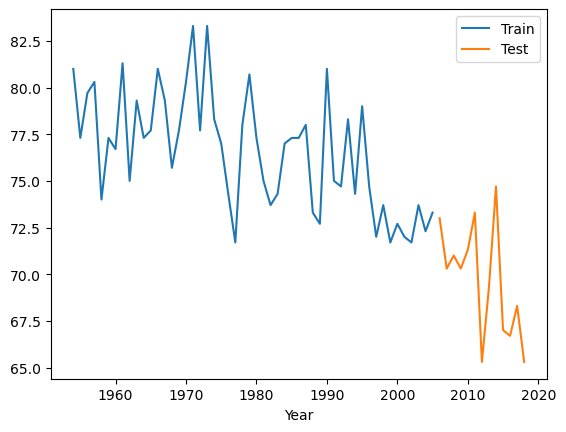

In [61]:
# 시각화로 확인하기.
train.plot(label='Train')
test.plot(label='Test')
plt.xlabel('Year')
plt.legend()
plt.show()

## 최적 차분 수 구하기
`pmdarima` 라이브러리를 통해 최적의 차분 수를 구함.

In [62]:
!pip install pmdarima

In [63]:
import pmdarima as pm

kpss_diffs = pm.arima.ndiffs(train, alpha=0.05, test='kpss', max_d=5)
adf_diffs = pm.arima.ndiffs(train, alpha=0.05, test='adf', max_d=5)
n_diffs = max(kpss_diffs, adf_diffs)

print(f"Optimized 'd' = {n_diffs}")

'''
Optimized 'd' = 0
'''

Optimized 'd' = 1


"\nOptimized 'd' = 0\n"

## Auto ARIMA를 통한 모델링


In [64]:
# 직접 지정해주어 모델링 실시
model = pm.auto_arima(y=train,		# 데이터
                      d=n_diffs,	# 차분 (d), 기본값 = None
                      start_p= 0,	# 시작 p값, 기본값 = 2
                      max_p = 5,	# p 최대값, 기본값 = 5
                      start_q= 0,	# 시작 q값, 기본값 = 2
                      max_q = 5,	# q 최대값, 기본값 = 5
                      m=1,			# season의 주기, 기본값 = 1
                      seasonal=False,	# sARIMA를 실시, 기본값 = True
                      stepwise=True,	# stepwise algorithm, 기본값 = True
                      trace=True)		# 각 step을 출력할지, 기본값 = False

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=274.153, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=265.129, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=272.252, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=262.196, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=263.020, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=260.556, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=263.336, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=261.520, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=256.180, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=254.222, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=252.341, Time=0.01 se

* 위에서는 0부터 지정하여 실시하였지만, 필요한 파라미터를 제외하고 모든 값을 기본값으로 설정하여 모델링을 다시 진행해

In [67]:
model2 = pm.auto_arima(train, d=1, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=274.153, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=265.129, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=272.252, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=262.196, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=263.020, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=260.556, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=263.336, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=261.520, Time=0.00 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=256.180, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=254.222, Time=0.02 sec
 A

## 최적화된 ARIMA 모델 분석

In [68]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   52
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -124.170
Date:                Fri, 17 May 2024   AIC                            252.341
Time:                        11:24:41   BIC                            256.204
Sample:                             0   HQIC                           253.817
                                 - 52                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7866      0.103     -7.623      0.000      -0.989      -0.584
sigma2         7.4830      1.767      4.235      0.000       4.020      10.946
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.95
Prob(Q):                              0.97   Prob(JB):                         0.62
Heteroskedasticity (H):               0.96   Skew:                             0.26
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* 시각화를 통한 정상성 확인
- Correlogram: ACF

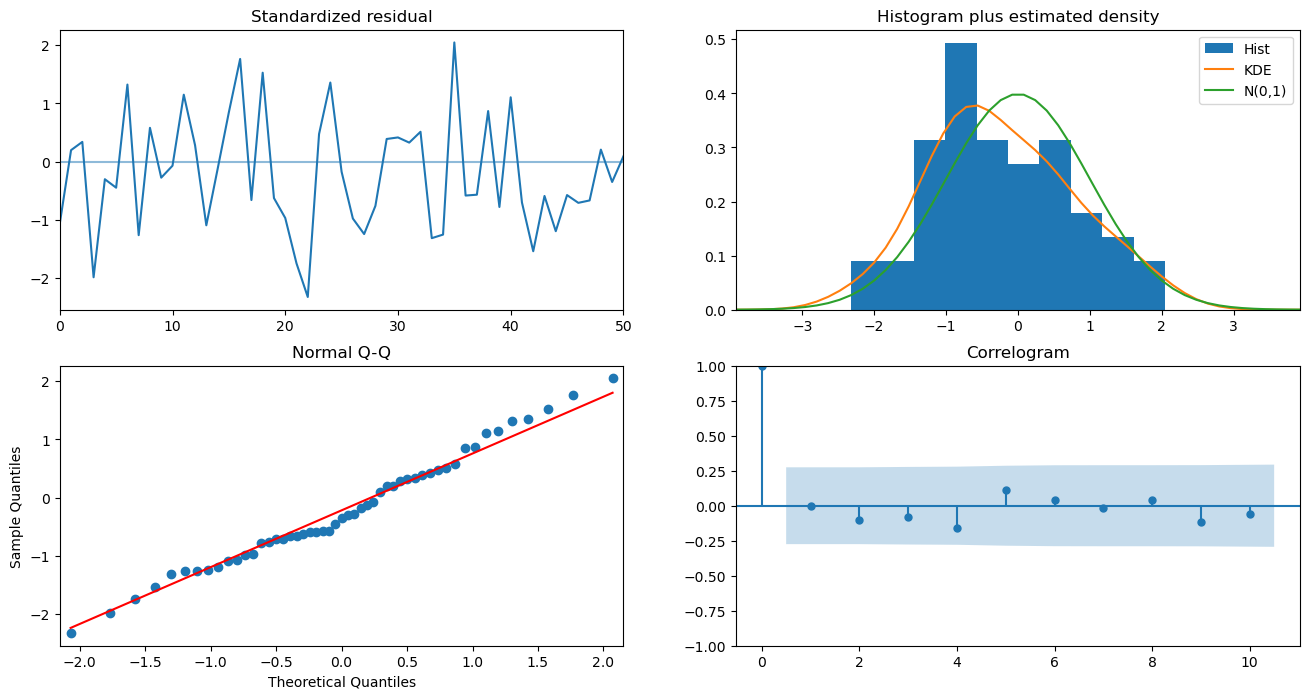

In [69]:
model2.plot_diagnostics(figsize=(16,8))
plt.show()

## 예측 및 평가

In [70]:
# 예측 -> 리스트로 변환
pred = model2.predict(n_periods=len(test)).to_list()
# 데이터프레임 생성
test_pred = pd.DataFrame({'test':test, 'pred':pred}, index=test.index)
test_pred

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,test,pred
일시,,
2006,73.0,73.103767
2007,70.3,73.103767
2008,71.0,73.103767
2009,70.3,73.103767
2010,71.3,73.103767
2011,73.3,73.103767
2012,65.3,73.103767
2013,69.3,73.103767
2014,74.7,73.103767


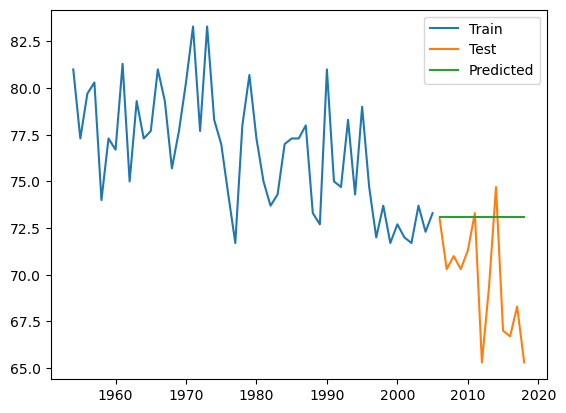

In [71]:
# 시각화
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test_pred.pred, label='Predicted')
plt.legend()
plt.show()

## 한 지점에 대한 예측을 진행하고, 모델을 업데이트 하는 방식

In [72]:
# one point forcast 함수 정의, 신뢰구간도 함께 담아보기
def forcast_one_step():
    fc, conf = model2.predict(n_periods=1, return_conf_int=True)
    return fc.tolist()[0], np.asarray(conf).tolist()[0]

# 값들을 담을 빈 리스트를 생성
y_pred = []
pred_upper = []
pred_lower = []

# for문을 통한 예측 및 모델 업데이트를 반복함
for new_ob in test:
    fc, conf = forcast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    model2.update(new_ob)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [73]:
# to dataframe
test_pred2 = pd.DataFrame({'test':test, 'pred':y_pred})
y_pred_df = test_pred2['pred']	# Series로 반환
y_pred_df

일시
2006    73.103767
2007    73.081177
2008    72.444129
2009    72.089303
2010    71.633400
2011    71.547665
2012    71.978948
2013    70.350053
2014    70.051451
2015    71.229151
2016    70.261888
2017    69.366127
2018    69.080449
Name: pred, dtype: float64

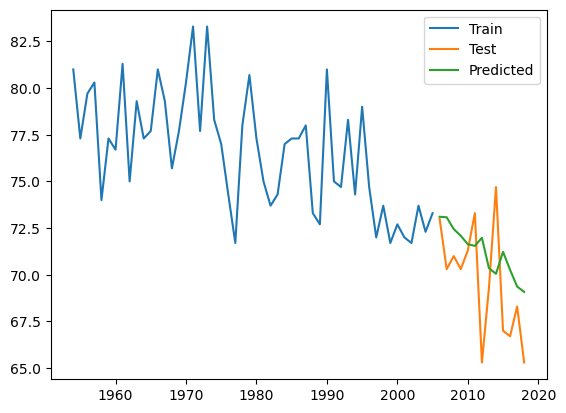

In [74]:
# 시각화
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_pred_df, label='Predicted')
plt.legend()
plt.show()

In [75]:
# 업데이트 된 모델 분석
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   65
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -157.662
Date:                Fri, 17 May 2024   AIC                            319.325
Time:                        11:25:05   BIC                            323.643
Sample:                             0   HQIC                           321.026
                                 - 65                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7405      0.099     -7.506      0.000      -0.934      -0.547
sigma2         7.9779      1.647      4.843      0.000       4.749      11.207
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 1.02
Prob(Q):                              0.60   Prob(JB):                         0.60
Heteroskedasticity (H):               0.95   Skew:                             0.26
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
# 예측 모델 오차 계산 (MAPE)
# sklearn으로 MAPE 계산
from sklearn.metrics import mean_absolute_percentage_error
print(f"MAPE : {mean_absolute_percentage_error(test, y_pred):.3f}")

MAPE : 0.037
